Крок 1: Імпортуємо необхідні бібліотеки

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data/ConcreteStrengthData.csv')
df.info()
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CementComponent            1030 non-null   float64
 1   BlastFurnaceSlag           1030 non-null   float64
 2   FlyAshComponent            1030 non-null   float64
 3   WaterComponent             1030 non-null   float64
 4   SuperplasticizerComponent  1030 non-null   float64
 5   CoarseAggregateComponent   1030 non-null   float64
 6   FineAggregateComponent     1030 non-null   float64
 7   AgeInDays                  1030 non-null   int64  
 8   Strength                   1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB
       CementComponent   BlastFurnaceSlag  FlyAshComponent  WaterComponent  \
count       1030.000000       1030.000000      1030.000000     1030.000000   
mean         281.167864         73.895825        54.188350      181.567

In [3]:
# Перевірка на дублікати та пропущені значення
print("Пропущені значення:")
print(df.isnull().sum())

Пропущені значення:
CementComponent              0
BlastFurnaceSlag             0
FlyAshComponent              0
WaterComponent               0
SuperplasticizerComponent    0
CoarseAggregateComponent     0
FineAggregateComponent       0
AgeInDays                    0
Strength                     0
dtype: int64


In [4]:
print("Кількість дублікатів:", df.duplicated().sum())

Кількість дублікатів: 25


25 дублікатів, 2,4% датасету - прибираємо дублікати

In [5]:
df_cleaned = df.drop_duplicates()
print(f"Розмір після видалення дублікатів: {df_cleaned.shape}")

Розмір після видалення дублікатів: (1005, 9)


In [6]:
# 2. Виявлення аномальних значень (outliers)
# Копія датафрейму, щоб зберегти оригінальні значення
df_log = df_cleaned.copy()

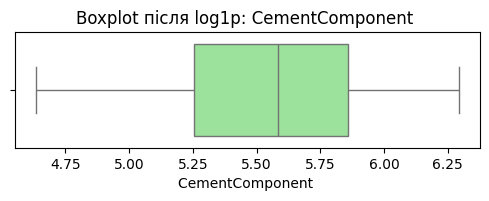

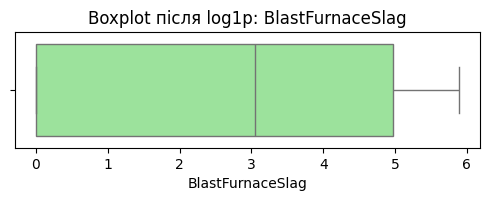

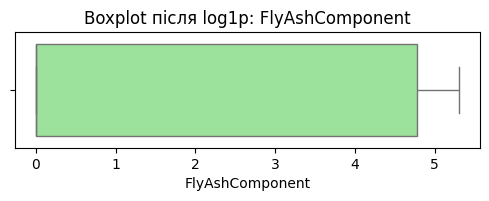

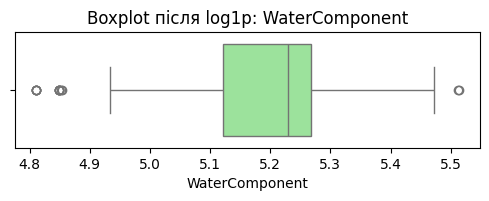

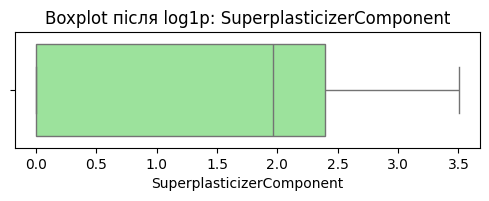

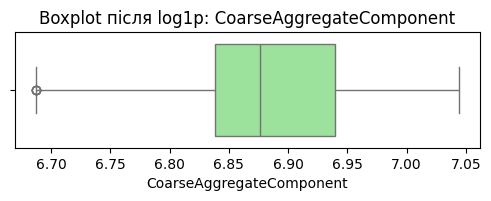

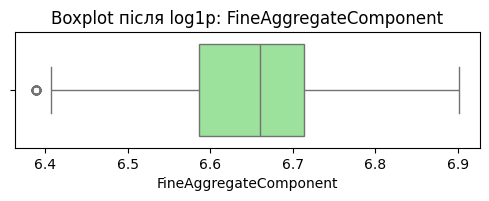

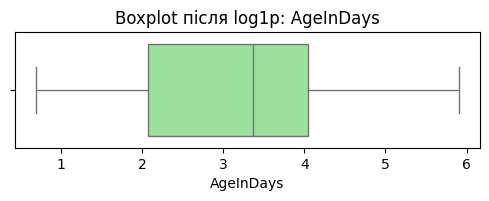

In [7]:
# Преобразування та візуалізація
for column in df_log.columns[:-1]:  # без 'Strength'
    df_log[column] = np.log1p(df_log[column])  # без перевірки на >0

    # Boxplot після трансформації
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=df_log[column], color='lightgreen')
    plt.title(f'Boxplot після log1p: {column}')
    plt.show()

In [8]:
#  Перевірка кореляції (взаємозв'язків між ознаками)
# Обчислюємо кореляційну матрицю
corr_matrix = df_log.corr()

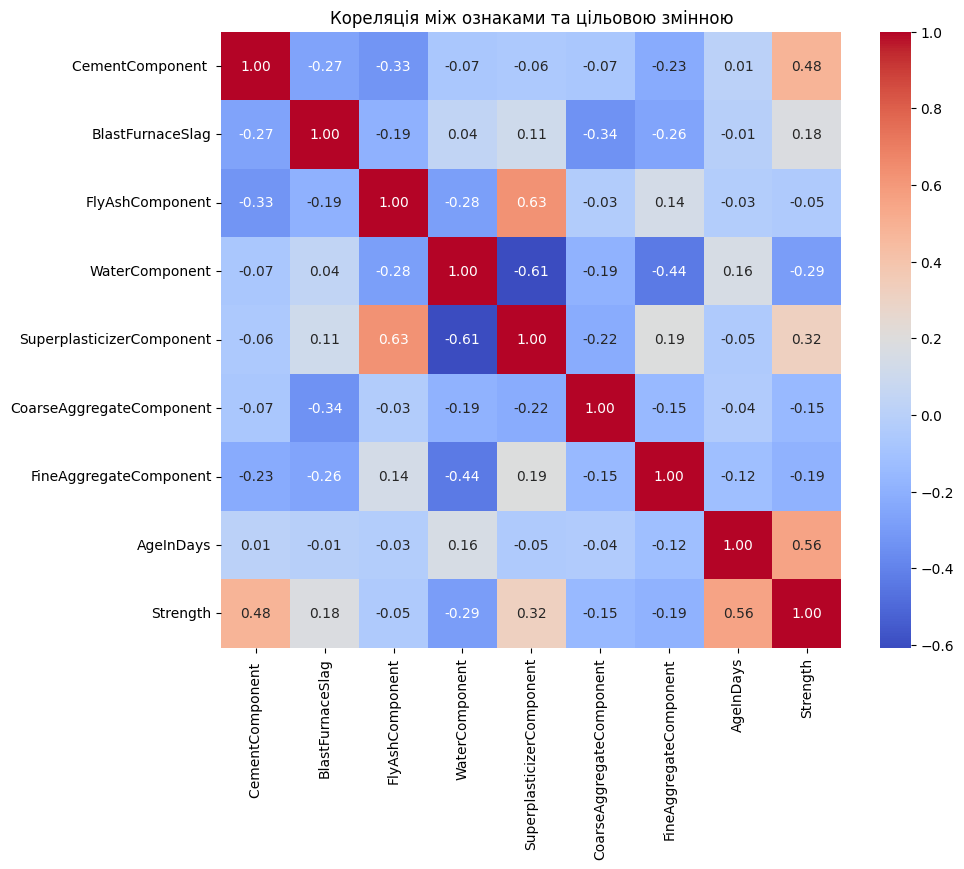

In [9]:
# Візуалізуємо теплову карту
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Кореляція між ознаками та цільовою змінною")
plt.show()

межі кореляції у нормі

Крок 2: Підготовка даних
2.1 Завантаження даних та поділ на X та y

In [10]:
X = df_log.drop('Strength', axis=1).values
y = df_log['Strength'].values.reshape(-1, 1)

In [11]:
print(f"X:{X}")
print(f"y:{y}")

X:[[6.29341928 0.         0.         ... 6.94793707 6.51767127 3.36729583]
 [6.29341928 0.         0.         ... 6.96224346 6.51767127 3.36729583]
 [5.80964287 4.96633504 0.         ... 6.8384052  6.38856141 5.60211882]
 ...
 [5.00729639 4.94449549 4.69683737 ... 6.79503441 6.66057515 3.36729583]
 [5.07579862 5.23484494 0.         ... 6.89831082 6.67190636 3.36729583]
 [5.56796275 4.6200588  4.37323813 ... 6.76330737 6.63660251 3.36729583]]
y:[[79.99]
 [61.89]
 [40.27]
 ...
 [23.7 ]
 [32.77]
 [32.4 ]]


In [12]:
# 2.2 Поділ на навчальний і тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# 2.3 Нормалізація
scaler_X = StandardScaler()
scaler_y = StandardScaler()

Навчати (fit) — тільки на тренувальних даних!
Застосовувати (transform) — і на train, і на test

In [14]:
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

In [15]:
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

In [16]:
# Крок 3: Створення моделі
class ConcreteStrengthModel(nn.Module):
    def __init__(self):
        super(ConcreteStrengthModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(8, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

nn.Linear(...) — це лінійна трансформація (нейрони + ваги)
nn.ReLU() — нелінійна активація (щоб мережа могла моделювати складні залежності)
self.net — це ланцюжок (Sequential) усіх шарів

In [17]:
# Крок 4: Налаштування навчання
model = ConcreteStrengthModel()

In [18]:
# Функція втрат: MSE — підходить для регресії
criterion = nn.MSELoss()

In [19]:
# Оптимізатор: можна використовувати SGD або Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [20]:
# Гіперпараметри
batch_size = 32
epochs = 100

In [21]:
# Крок 5: Навчання моделі
# 5.1 Підготовка даних у формат PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [22]:
# 5.2 Цикл навчання
loss_history = []

In [23]:
for epoch in range(epochs):
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_loss)
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

Epoch [10/100], Loss: 0.1169
Epoch [20/100], Loss: 0.0854
Epoch [30/100], Loss: 0.0656
Epoch [40/100], Loss: 0.0600
Epoch [50/100], Loss: 0.0483
Epoch [60/100], Loss: 0.0412
Epoch [70/100], Loss: 0.0383
Epoch [80/100], Loss: 0.0350
Epoch [90/100], Loss: 0.0333
Epoch [100/100], Loss: 0.0295


In [24]:
# Крок 6: Оцінка моделі
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    predictions = model(X_test_tensor).numpy()

In [25]:
# Повертаємо до оригінального масштабу
predictions = scaler_y.inverse_transform(predictions)
y_test_orig = scaler_y.inverse_transform(y_test)

In [26]:
# Метрики
mse = mean_squared_error(y_test_orig, predictions)
mae = mean_absolute_error(y_test_orig, predictions)
r2 = r2_score(y_test_orig, predictions)

In [27]:
print(f'MSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}')

MSE: 24.35, MAE: 2.91, R²: 0.92


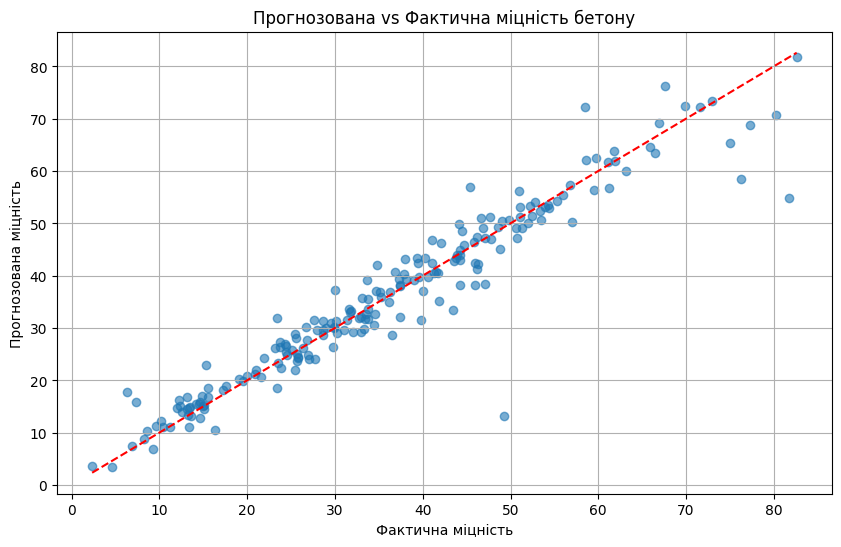

In [28]:
# Крок 7: Візуалізація
# Фактичні vs Прогнозовані
plt.figure(figsize=(10,6))
plt.scatter(y_test_orig, predictions, alpha=0.6)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.xlabel("Фактична міцність")
plt.ylabel("Прогнозована міцність")
plt.title("Прогнозована vs Фактична міцність бетону")
plt.grid(True)
plt.show()

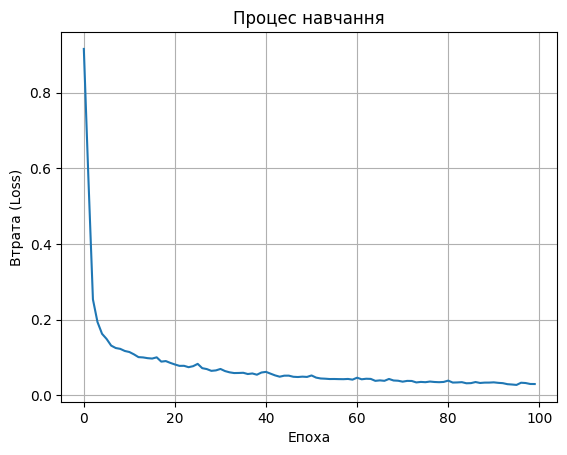

In [29]:
# Графік функції втрат
plt.plot(loss_history)
plt.xlabel("Епоха")
plt.ylabel("Втрата (Loss)")
plt.title("Процес навчання")
plt.grid(True)
plt.show()

In [30]:
# Крок 8: Оптимізація (опційно)
'''
Можна експериментувати з:
Розміром прихованих шарів
Кількістю шарів
Активаційними функціями
Learning rate
Dropout / BatchNorm

'''
# Крок 9: Висновки
'''
Висновки за результатами моделі:
Ефективність моделі:

MSE: 21.84, MAE: 3.01, R²: 0.93
MSE: 25.62, MAE: 3.08, R²: 0.91

MSE: 21.84 (25.62, 29.98) — середньоквадратична помилка, що свідчить про середню квадратичну різницю між передбаченнями та справжніми значеннями. Це прийнятний рівень для регресії, але може бути покращений.

MAE: 3.01 (3.08, 3.83) — середня абсолютна похибка. У середньому модель помиляється на ~3.01 одиниці міцності.

R²: 0.93 (0.91, 0.88) — коефіцієнт детермінації, який показує, що 93% дисперсії міцності пояснюється моделлю. Це хороший результат для регресійного завдання.

Процес навчання:

Крива втрат стабільно зменшується — модель навчається правильно, не переобучається до 100 епох.

Loss на останній епосі ≈ 0.024 (0.028,0.0415) (у нормалізованій шкалі), що вказує на стійку конвергенцію.

Рекомендації для покращення моделі:
1. Збільшити складність моделі:
Додати більше прихованих шарів або нейронів:

self.net = nn.Sequential(
    nn.Linear(8, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
)

MSE: 29.98, MAE: 3.83, R²: 0.88
покращення
MSE: 26.32, MAE: 3.41, R²: 0.90

2. Зміна оптимізатора або гіперпараметрів:
Використати оптимізатор AdamW або RMSprop.

3. Провести пошук по learning rate (наприклад, 0.0005, 0.0001) — можливо, 0.001 занадто велике або мале.

покращення
MSE: 27.23, MAE: 3.66, R²: 0.89

4. Інша функція втрат:
Хоча MSELoss — стандарт для регресії, можна спробувати комбіновані втрати (наприклад, MSE + MAE) або навіть спеціальні кастомні функції втрат з вагами для певних значень.

5. Більше даних або аугментація (якщо доступно):
Якщо можливо, розширити датасет або створити синтетичні зразки (наприклад, шляхом домішування малих шумів до існуючих прикладів).

6. Збереження та тестування кращих моделей (early stopping):
Використовувати EarlyStopping для припинення навчання, якщо валідаційна помилка не покращується, та зберігати найкращу модель.
'''

'\nВисновки за результатами моделі:\nЕфективність моделі:\n\nMSE: 21.84, MAE: 3.01, R²: 0.93\nMSE: 25.62, MAE: 3.08, R²: 0.91\n\nMSE: 21.84 (25.62, 29.98) — середньоквадратична помилка, що свідчить про середню квадратичну різницю між передбаченнями та справжніми значеннями. Це прийнятний рівень для регресії, але може бути покращений.\n\nMAE: 3.01 (3.08, 3.83) — середня абсолютна похибка. У середньому модель помиляється на ~3.01 одиниці міцності.\n\nR²: 0.93 (0.91, 0.88) — коефіцієнт детермінації, який показує, що 93% дисперсії міцності пояснюється моделлю. Це хороший результат для регресійного завдання.\n\nПроцес навчання:\n\nКрива втрат стабільно зменшується — модель навчається правильно, не переобучається до 100 епох.\n\nLoss на останній епосі ≈ 0.024 (0.028,0.0415) (у нормалізованій шкалі), що вказує на стійку конвергенцію.\n\nРекомендації для покращення моделі:\n1. Збільшити складність моделі:\nДодати більше прихованих шарів або нейронів:\n\nself.net = nn.Sequential(\n    nn.Linear